In [1]:
import numpy as np
from scipy.optimize import fsolve
import pandas as pd #to read experimental values from excel

%matplotlib notebook
from matplotlib import pyplot as plt

In [2]:
#FUNCTIONS

#component 1: methanol
#component 2: methyl acetate

#constants
antoine_coeff = [[16.5785, 14.2456], [3638.27, 2662.78], [239.5, 219.69]]
A, B, C = antoine_coeff
R_wilson = 1.987 #cal/(mol*K)

def vap_pressure(T, comp): #kPa
    return np.e**(A[comp-1] - (B[comp-1]/(T + C[comp-1])))

def sat_temperature(P, comp): #C
    return (B[comp-1]/(A[comp-1] - np.log(P))) - C[comp-1]

def gamma_van_laar(x1,comp, A12, A21):
    if comp == 1:
        return np.e**(A12*(1 + (A12*x1)/(A21*(1-x1)))**-2)
    
    if comp == 2:
        return np.e**(A21*(1 + (A21*(1-x1))/(A12*x1))**-2)
    
def coeff_wilson(T, V1, V2, a12, a21):
    A12 = (V2/V1)*np.e**(-a12/(R_wilson*(T+273.15)))
    A21 = (V1/V2)*np.e**(-a21/(R_wilson*(T+273.15)))
    
    return A12, A21
    
def gamma_wilson(T, x1, comp, V1, V2, a12, a21):
    A12, A21 = coeff_wilson(T, V1, V2, a12, a21)
    
    last_term = A12/(x1 + (1-x1)*A12) - A21/((1-x1) + x1*A21) #both formulae share this term
    if comp == 1:
        return np.e**(-np.log(x1 + (1-x1)*A12) + (1-x1)*last_term)
    
    if comp == 2:
        return np.e**(-np.log((1-x1) + x1*A21) - x1*last_term)

In [3]:
#1 [rearranged van Laar equations, no fsolve]

P = 101.325 #kPa
T = 53.5 #deg celcius
x1 = 0.352

#at azeotrope, z1=y1=x1. Therefor modified Raoult's law simplifies to P = gamma_i * vap_p_i
Pvap1 = vap_pressure(53.5, 1)
Pvap2 = vap_pressure(53.5, 2)

gamma1 = P/Pvap1
gamma2 = P/Pvap2

#using rearranged van Laar equations
A12 = np.log(gamma1)*(1 + ((1 - x1)*np.log(gamma2))/(x1*np.log(gamma1)))**2
A21 = np.log(gamma2)*(1 + (x1*np.log(gamma1))/((1 - x1)*np.log(gamma2)))**2


print("Al2 =", A12)
print("A21 =", A21)

Al2 = 1.0041931469871552
A21 = 1.1314185285222502


In [13]:
#2 [fixed point iteration method, no fsolve]

#variables
P = 101.325 #kPa
y1 = 0.5 #since at dewpoint y1 = z1 = 0.5
tolerance = 1e-10

#Calc Tsat for pure components and guess T
Tsat1 = sat_temperature(P, 1)
Tsat2 = sat_temperature(P, 2)
T = y1*Tsat1 + (1-y1)*Tsat2

#Calc Pvap for components at guess T
Pvap1 = vap_pressure(T, 1)
Pvap2 = vap_pressure(T, 2)

#Calc a guess for x1 when gamma1 = 1
x1 = y1*P/Pvap1

#Fixed point iteration loop to find Pvap1 within the given tolerance limit
error = tolerance*1.1  #set error to any value bigger than tolerance to start the loop
while (tolerance < error):
    #Calc gamma values from van Laar equations
    gamma1 = gamma_van_laar(x1, 1, A12, A21)
    gamma2 = gamma_van_laar(x1, 2, A12, A21)
    
    #Calc new Pvap1_new with FPI formula
    Pvap1_new = P*(y1/gamma1 + ((1-y1)*Pvap1)/(gamma2*Pvap2))
    error = np.abs(Pvap1_new - Pvap1)
    Pvap1 = Pvap1_new
    
    #Calc new T, Pvap2 and x1
    T = sat_temperature(Pvap1, 1)
    Pvap2 = vap_pressure(T, 2)
    x1 = y1*P/(Pvap1*gamma1) #using old gamma1
print("Dewpoint Temperature: ", T)
print("x1:", x1)
print("x2:", 1-x1)  

Dewpoint Temperature:  54.67580111176056
x1: 0.6526009183823039
x2: 0.34739908161769606


In [5]:
#2 [using fsolve - function defined to simplify question 5]

#variables
P = 101.325 #kPa
y1 = 0.5 #since at dewpoint y1 = z1 = 0.5

#guess variables
Tsat1 = sat_temperature(P, 1)
Tsat2 = sat_temperature(P, 2)

def equations_dew_point_van_laar(var, y1, P):
    T, x1 = var
    
    gamma1 = gamma_van_laar(x1, 1, A12, A21)
    gamma2 = gamma_van_laar(x1, 2, A12, A21)
    
    Pvap1 = vap_pressure(T, 1)
    Pvap2 = vap_pressure(T, 2)

    f1 = P*y1 - x1*Pvap1*gamma1
    f2 = P*(1-y1) - (1-x1)*Pvap2*gamma2
    
    return [f1, f2]

def dew_point_van_laar(P, y1, Tsat1, Tsat2):

    #Calc Tsat for pure components and guess T
    T = y1*Tsat1 + (1-y1)*Tsat2

    #Calc Pvap_1 at guess T
    Pvap1 = vap_pressure(T, 1)

    #Calc a guess for x1 when gamma1 = 1
    x1 = y1*P/Pvap1
    
    args = (y1, P)
    return fsolve(equations_dew_point_van_laar, [T, x1], args)

T, x1 = dew_point_van_laar(P, y1, Tsat1, Tsat2)
print("Dewpoint Temperature: ", T)
print("x1:", x1)
print("x2:", 1-x1)

Dewpoint Temperature:  54.67580111176374
x1: 0.6526011516487568
x2: 0.34739884835124324


In [12]:
#3 [using fsolve]

#constants
a12 = 813.18 #cal*mol^-1
a21 = -31.19 #cal*mol^-1
V1 = 40.73 #cm^3*mol^-1
V2 = 79.84 #cm^3*mol^-1

#variables
P = 101.325 #kPa

def equations_wilson_azeotrope(var):
    T, x1 = var
    
    A12, A21 = coeff_wilson(T, V1, V2, a12, a21)
    
    #equations
    last_term = A12/(x1 + (1-x1)*A12) - A21/((1-x1) + x1*A21) #both formulae share this term
    ln_gamma1 = -np.log(x1 + (1-x1)*A12) + (1-x1)*last_term
    ln_gamma2 = -np.log((1-x1) + x1*A21) - x1*last_term
    
    Pvap1 = vap_pressure(T, 1)
    Pvap2 = vap_pressure(T, 2)
    
    f1 = np.log(P/Pvap1) - ln_gamma1
    f2 = np.log(P/Pvap2) - ln_gamma2
    
    return [f1, f2]
    
#Calc Tsat for pure components and guess T
Tsat1 = sat_temperature(P, 1)
Tsat2 = sat_temperature(P, 2)
T = (Tsat1 + Tsat2)/0.5

#guess x1
x1 = 0.5

#Calc T and x1 using fsolve
T, x1 = fsolve(equations_wilson_azeotrope, [T, x1])

print("Azeotropic T:", T, "C")
print("Azeotropic composition: z1 = ", x1)

Azeotropic T: 53.61416573141449 C
Azeotropic composition: z1 =  0.3339498027811398


In [7]:
#4 [fixed point iteration method, no fsolve]

#constants
a12 = 813.18 #cal*mol^-1
a21 = -31.19 #cal*mol^-1
V1 = 40.73 #cm^3*mol^-1
V2 = 79.84 #cm^3*mol^-1

#variables
P = 101.325 #kPa
y1 = 0.5 #since at dewpoint y1 = z1 = 0.5
tolerance = 1e-10

#Calc Tsat for pure components and guess T
Tsat1 = sat_temperature(P, 1)
Tsat2 = sat_temperature(P, 2)
T = y1*Tsat1 + (1-y1)*Tsat2

#Calc Pvap for components at guess T
Pvap1 = vap_pressure(T, 1)
Pvap2 = vap_pressure(T, 2)

#Calc a guess for x1 when gamma1 = 1
x1 = y1*P/Pvap1

#Fixed point iteration loop to find Pvap1 within the given tolerance limit
error = tolerance*1.1  #set error to any value bigger than tolerance to start the loop
while (tolerance < error):
    #Calc gamma values from Wilson equations
    gamma1 = gamma_wilson(T, x1, 1, V1, V2, a12, a21)
    gamma2 = gamma_wilson(T, x1, 2, V1, V2, a12, a21)
    
    #Calc new Pvap1_new with FPI formula
    Pvap1_new = P*(y1/gamma1 + ((1-y1)*Pvap1)/(gamma2*Pvap2))
    error = np.abs(Pvap1_new - Pvap1)
    Pvap1 = Pvap1_new
    
    #Calc new T, Pvap2 and x1
    T = sat_temperature(Pvap1, 1)
    Pvap2 = vap_pressure(T, 2)
    x1 = y1*P/(Pvap1*gamma1) #using old gamma1
print("Dewpoint Temperature: ", T)
print("x1:", x1)
print("x2:", 1-x1)

Dewpoint Temperature:  54.996197284769266
x1: 0.6517903450163579
x2: 0.3482096549836421


In [8]:
#4 [fsolve method]

#constants
a12 = 813.18 #cal*mol^-1
a21 = -31.19 #cal*mol^-1
V1 = 40.73 #cm^3*mol^-1
V2 = 79.84 #cm^3*mol^-1

#variables
P = 101.325 #kPa
y1 = 0.5 #since at dewpoint y1 = z1 = 0.5

#guess variables
Tsat1 = sat_temperature(P, 1)
Tsat2 = sat_temperature(P, 2)

def equations_dew_point_wilson(var, y1, P):
    T, x1 = var
    
    gamma1 = gamma_wilson(T, x1, 1, V1, V2, a12, a21)
    gamma2 = gamma_wilson(T, x1, 2, V1, V2, a12, a21)
    
    Pvap1 = vap_pressure(T, 1)
    Pvap2 = vap_pressure(T, 2)

    f1 = P*y1 - x1*Pvap1*gamma1
    f2 = P*(1-y1) - (1-x1)*Pvap2*gamma2
    
    return [f1, f2]

def dew_point_wilson(P, y1, Tsat1, Tsat2):

    #Calc Tsat for pure components and guess T
    T = y1*Tsat1 + (1-y1)*Tsat2

    #Calc Pvap_1 at guess T
    Pvap1 = vap_pressure(T, 1)

    #Calc a guess for x1 when gamma1 = 1
    x1 = y1*P/Pvap1
    
    args = (y1, P)
    return fsolve(equations_dew_point_wilson, [T, x1], args)

T, x1 = dew_point_wilson(P, y1, Tsat1, Tsat2)
print("Dewpoint Temperature: ", T)
print("x1:", x1)
print("x2:", 1-x1)

Dewpoint Temperature:  54.996197284659715
x1: 0.6517905340020911
x2: 0.3482094659979089


<IPython.core.display.Javascript object>


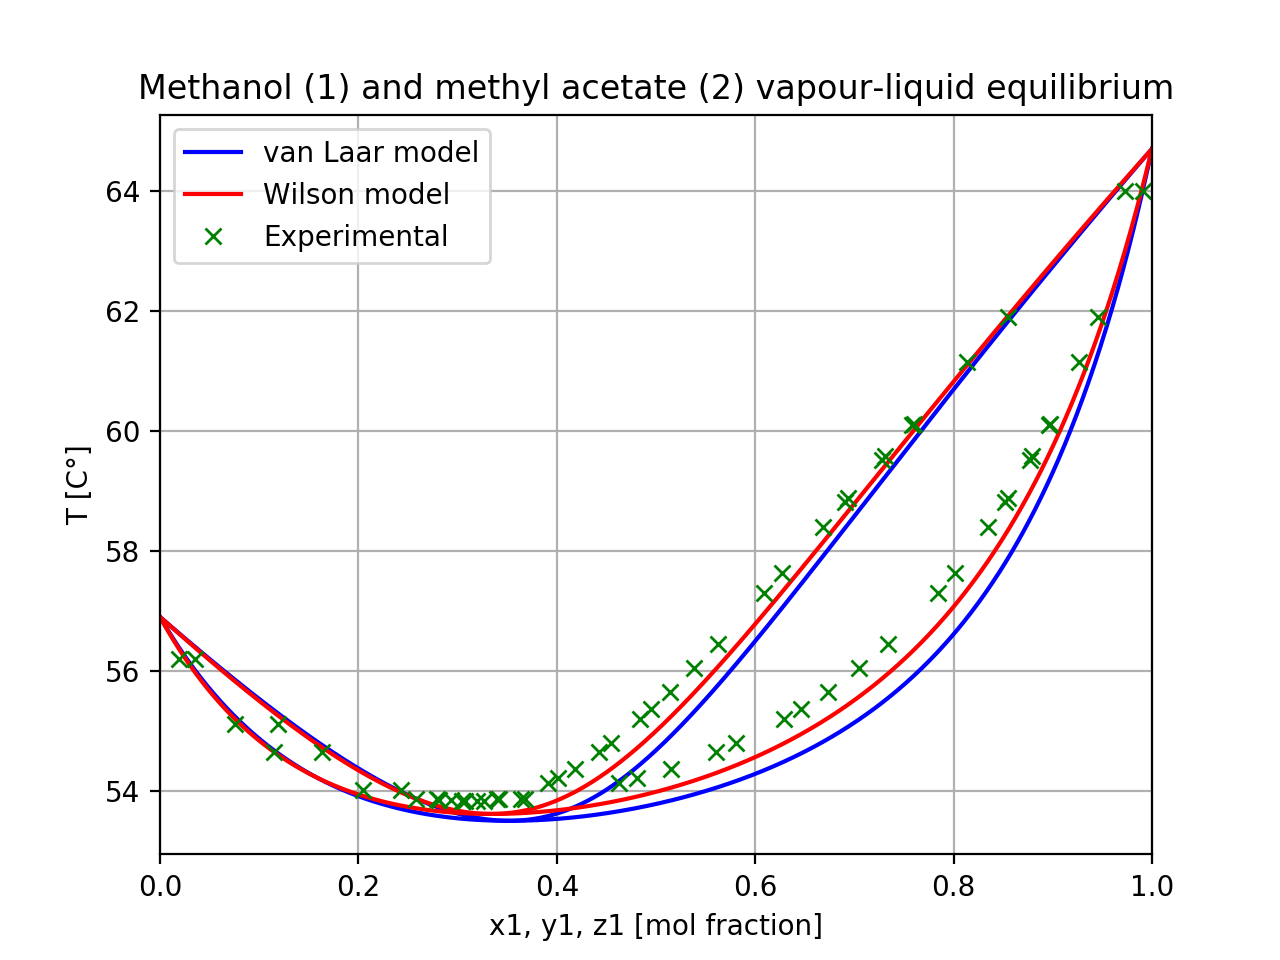

In [11]:
#5

#constants
a12 = 813.18 #cal*mol^-1
a21 = -31.19 #cal*mol^-1
V1 = 40.73 #cm^3*mol^-1
V2 = 79.84 #cm^3*mol^-1

#variables
P = 101.325 #kPa
z1_offset = 1e-5 #to ensure no divide-by-zero errors occurr in gamma calculations (this varibale cannot be 0)

#guess variables
Tsat1 = sat_temperature(P, 1)
Tsat2 = sat_temperature(P, 2)

#graph setup
def plot_setup():
    plt.figure(1)
    plt.title("Methanol (1) and methyl acetate (2) vapour-liquid equilibrium")
    plt.xlabel("x1, y1, z1 [mol fraction]")
    plt.ylabel("T [C°]")
    plt.legend(loc = "upper left")
    plt.grid(True)
    plt.xlim(0, 1)
    plt.show()

#Dew point functions defined in question 2 and 4

#Bubble point functions
def equations_bubble_point_van_laar(var, gamma1, gamma2, x1, P):
    T = var
    
    Pvap1 = vap_pressure(T, 1)
    Pvap2 = vap_pressure(T, 2)

    return Pvap1*x1*gamma1 + Pvap2*(1-x1)*gamma2 - P

def bubble_point_van_laar(P, x1, Tsat1, Tsat2):
    #guess T
    T = x1*Tsat1 + (1-x1)*Tsat2
    
    gamma1 = gamma_van_laar(x1, 1, A12, A21)
    gamma2 = gamma_van_laar(x1, 2, A12, A21)
    
    args = (gamma1, gamma2, x1, P)
    return fsolve(equations_bubble_point_van_laar, T, args)

def equations_bubble_point_wilson(var, x1, P):
    T = var
    
    gamma1 = gamma_wilson(T, x1, 1, V1, V2, a12, a21)
    gamma2 = gamma_wilson(T, x1, 2, V1, V2, a12, a21)
    
    return vap_pressure(T, 1)*x1*gamma1 + vap_pressure(T, 2)*(1-x1)*gamma2 - P
    
def bubble_point_wilson(P, x1, Tsat1, Tsat2):
    #guess T
    T = x1*Tsat1 + (1-x1)*Tsat2
    
    args = (x1, P)
    return fsolve(equations_bubble_point_wilson, T, args)

#drawing van Laar graph
T_van_laar = [[], [], []]
for z1 in np.linspace(0+z1_offset, 1-z1_offset, 1000):
    T_van_laar[0].append(z1)
    T_van_laar[1].append(bubble_point_van_laar(P, z1, Tsat1, Tsat2))
    T_van_laar[2].append(dew_point_van_laar(P, z1, Tsat1, Tsat2)[0])
plt.plot(T_van_laar[0], T_van_laar[1], 'b', label = "van Laar model")
plt.plot(T_van_laar[0], T_van_laar[2], 'b', label = "")

#drawing Wilson graph
T_wilson = [[], [], []]
for z1 in np.linspace(0+z1_offset, 1-z1_offset, 1000):
    T_wilson[0].append(z1)
    T_wilson[1].append(bubble_point_wilson(P, z1, Tsat1, Tsat2))
    T_wilson[2].append(dew_point_wilson(P, z1, Tsat1, Tsat2)[0])
plt.plot(T_wilson[0], T_wilson[1], 'r', label = "Wilson model")
plt.plot(T_wilson[0], T_wilson[2], 'r', label = "")

#drawing experimental data graph
pd_list = pd.read_csv("vle_experimental_data.csv")
plt.plot(pd_list["x1:"], pd_list["T:"], "gx", label = "Experimental")
plt.plot(pd_list["y1:"], pd_list["T:"], "gx", label = "")

plot_setup()